# Нейронки или градиентный бустинг? Что лучше для табличных биоданных?
## Часть 1 - бустинги

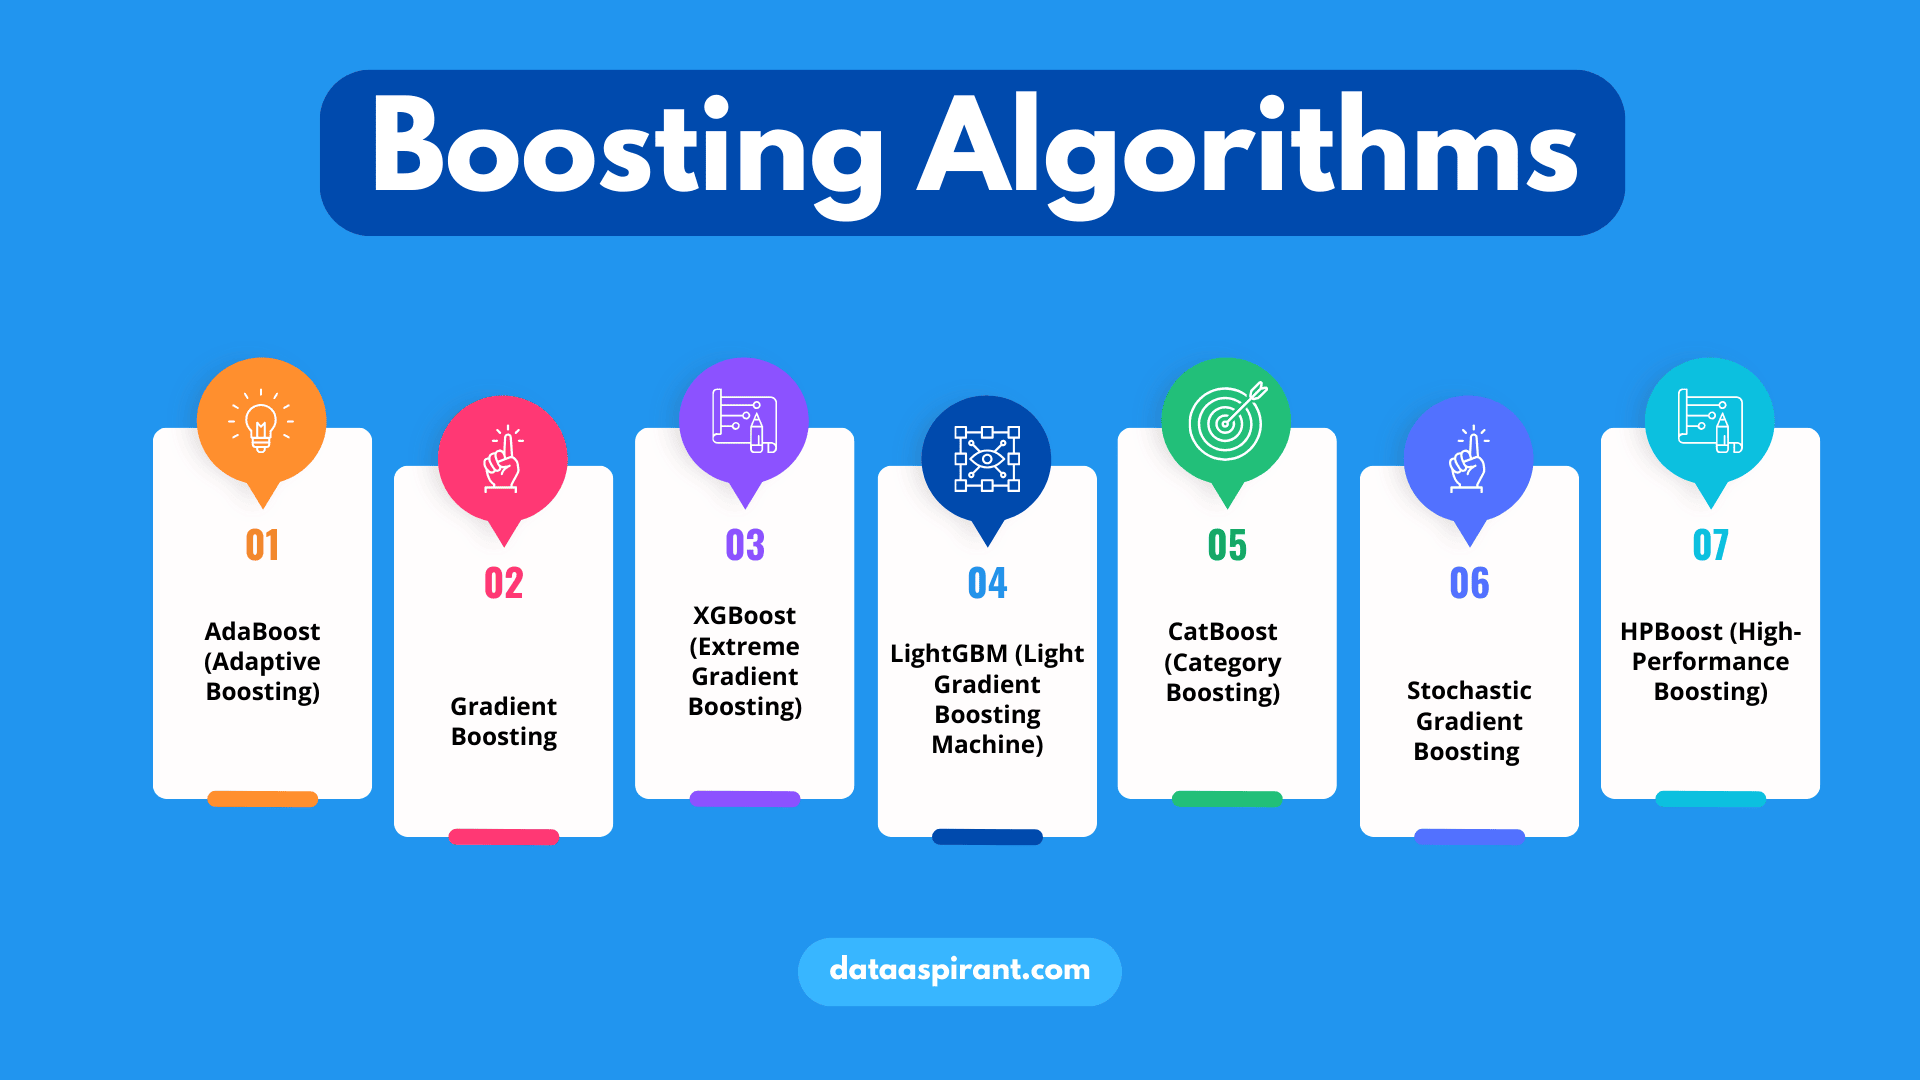

In [1]:
from IPython.display import Image
Image("figure1.png")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.dummy import DummyClassifier

## 1. Загрузка и обработка данных

Thyroid disease patient dataset
"Comprehensive Thyroid Diagnosis Dataset: Attributes and Classifications
https://www.kaggle.com/datasets/kapoorprakhar/thyroid-disease-patient-dataset?select=hypothyroid.csv

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head()

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,TT4measured,T4,T4Umeasured,T4U,FTImeasured,FTI,TBGmeasured,TBG,referral source,binaryClass
0,12,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,?,SVHC,P
1,20,M,f,f,f,f,f,f,f,f,...,t,102.0,f,0.00,f,0.0,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175.0,f,0.00,f,0.0,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,?,SVI,P


In [5]:
columns_to_drop = ['referral source', 'TBG', 'TSHmeasured', 'T3measured', 'T4Umeasured','TT4measured', 'FTImeasured', 'TBGmeasured']
df.drop(columns=columns_to_drop, inplace=True)
df = df.replace({'f': 0, 't': 0})
df = df.replace({'F': 0, 'M': 1})
df = df.replace({'N': 0, 'P': 1})
df = df.dropna()
df['sex'] = df['sex'].astype(int)


C:\Users\demet\AppData\Local\Temp\ipykernel_17368\336845337.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'f': 0, 't': 0})
C:\Users\demet\AppData\Local\Temp\ipykernel_17368\336845337.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'F': 0, 'M': 1})
C:\Users\demet\AppData\Local\Temp\ipykernel_17368\336845337.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=Fal

In [6]:
df.head()

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,T4,T4U,FTI,binaryClass
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.30,2.5,125.0,1.14,109.0,1
1,20,1,0,0,0,0,0,0,0,0,...,0,0,0,0,4.10,2.0,102.0,0.00,0.0,1
2,46,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.98,0.0,109.0,0.91,120.0,1
3,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.16,1.9,175.0,0.00,0.0,1
4,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.72,1.2,61.0,0.87,70.0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3620 entries, 0 to 3769
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3620 non-null   int64  
 1   sex                      3620 non-null   int32  
 2   thyroxine                3620 non-null   int64  
 3   queryonthyroxine         3620 non-null   int64  
 4   onantithyroidmedication  3620 non-null   int64  
 5   sick                     3620 non-null   int64  
 6   pregnant                 3620 non-null   int64  
 7   thyroidsurgery           3620 non-null   int64  
 8   I131treatment            3620 non-null   int64  
 9   queryhypothyroid         3620 non-null   int64  
 10  queryhyperthyroid        3620 non-null   int64  
 11  lithium                  3620 non-null   int64  
 12  goitre                   3620 non-null   int64  
 13  tumor                    3620 non-null   int64  
 14  hypopituitary            3620

In [8]:
df['binaryClass'].sum()/df.shape[0]

0.9226519337016574

In [9]:
#Нормализация данных
df[['TSH', 'T3', 'T4', 'T4U', 'FTI']]=(df[['TSH', 'T3', 'T4', 'T4U', 'FTI']]-df[['TSH', 'T3', 'T4', 'T4U', 'FTI']].mean())/df[['TSH', 'T3', 'T4', 'T4U', 'FTI']].std()

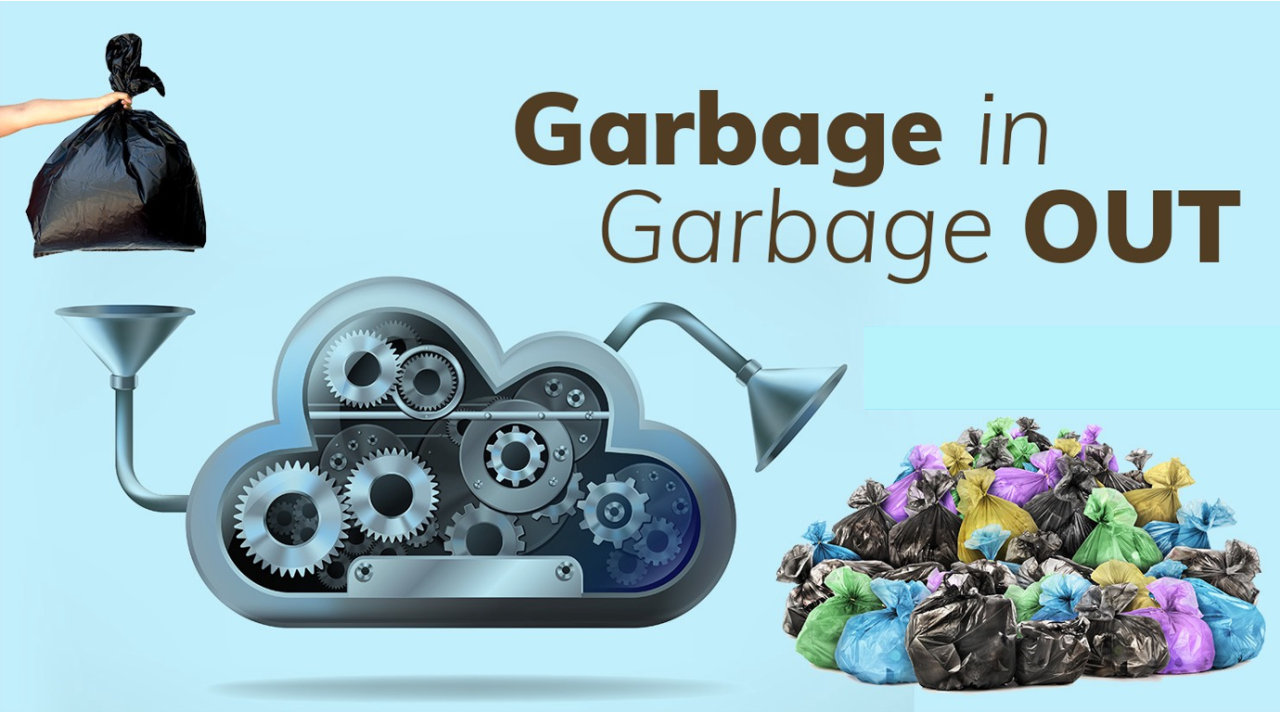

In [10]:
Image("figure2.png")

## 2. Кросс валидация моделей

In [11]:
def cross_val_func(model, X, y):
    scores_acc = cross_val_score(model, X, y, cv=10, scoring='balanced_accuracy')
    scores_f1 = cross_val_score(model, X, y, cv=10, scoring='f1')
    scores_roc_auc = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    return scores_acc, scores_f1, scores_roc_auc

In [12]:
y = df['binaryClass']
df_ = df.drop(['binaryClass'], axis = 1)
X = df_
column_names = X.columns

In [13]:
model_dict = {}
model_dict['Dummy'] = DummyClassifier(strategy="most_frequent")
model_dict['LogReg'] = LogisticRegression(random_state=42, max_iter=1000)
model_dict['XGBoost'] = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
model_dict['LGBoost'] = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42,verbose=-1)
model_dict['CatBoost'] = CatBoostClassifier(iterations=100,learning_rate=0.1,depth=6,verbose=0)

In [14]:
scoring_results_acc = {}
scoring_results_f1 = {}
scoring_results_roc_auc = {}
for model_name, model in model_dict.items():
    scores_acc, scores_f1, scores_roc_auc = cross_val_func(model, X, y)
    scoring_results_acc[model_name] = scores_acc  
    scoring_results_f1[model_name] = scores_f1
    scoring_results_roc_auc[model_name] = scores_roc_auc

In [15]:
df_acc = pd.DataFrame(scoring_results_acc)
df_f1 = pd.DataFrame(scoring_results_f1)
df_roc_auc = pd.DataFrame(scoring_results_roc_auc)

Dummy       0.500000
LogReg      0.712329
XGBoost     0.546418
LGBoost     0.950994
CatBoost    0.950695
dtype: float64

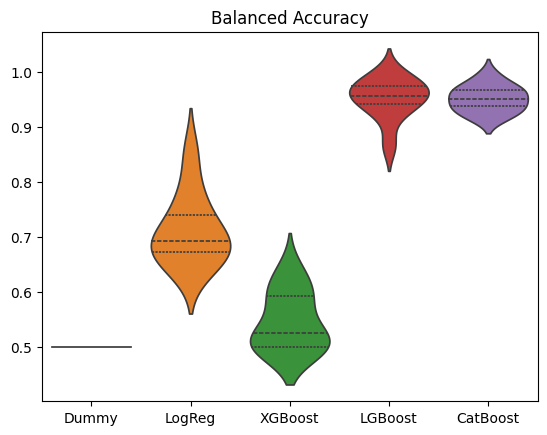

In [16]:
sns.violinplot(data=df_acc, inner="quart").set_title("Balanced Accuracy")
df_acc.mean()

Dummy       0.959770
LogReg      0.973014
XGBoost     0.961722
LGBoost     0.988568
CatBoost    0.988260
dtype: float64

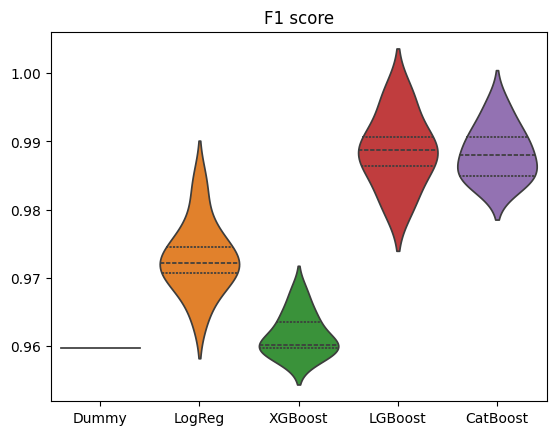

In [17]:
sns.violinplot(data=df_f1, inner="quart").set_title("F1 score")
df_f1.mean()

Dummy       0.500000
LogReg      0.983565
XGBoost     0.124145
LGBoost     0.989040
CatBoost    0.992665
dtype: float64

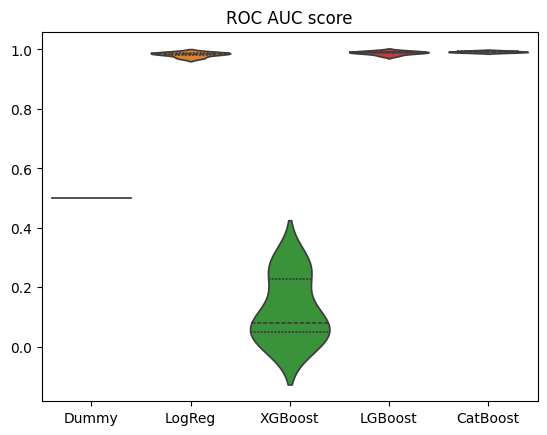

In [18]:
sns.violinplot(data=df_roc_auc, inner="quart").set_title("ROC AUC score")
df_roc_auc.mean()

## 3. Тренировка выбранной модели

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [20]:
model = CatBoostClassifier(iterations=100,learning_rate=0.1,depth=6,verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [21]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

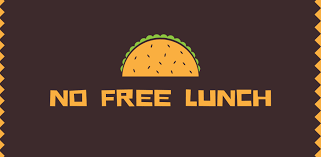

In [22]:
Image("figure3.png")